In [4]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
# from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [89]:
model_listing = [x for x in glob.glob('/home/leachl/Documents/Datasets/CMIP6/CMIP6_TCRE/CMIP6_TCRE/*') if 'data.txt' in x]
models =  [x.split('/')[-1].split('_')[0] for x in model_listing]
model_1pct = pd.concat([pd.read_csv(x,delim_whitespace=True,header=None,names=['year','E','T'],index_col=0) for x in model_listing],axis=1,keys=models)

In [90]:
conc_1pct = pd.read_csv('/home/leachl/Documents/Datasets/CMIP6/CMIP6_TCRE/CMIP6_TCRE/CO2atm_1pctCO2.txt',delim_whitespace=True,index_col=0)

In [199]:
for model in models:
    model_1pct[(model,'airbourne_fraction')] = (conc_1pct['CO2(ppm)'].diff().loc[:1989])/(model_1pct[(model,'E')].shift().replace(np.nan,0).diff()*0.468952)
    model_1pct[(model,'cumulative_uptake')] = (model_1pct[(model,'E')]) - (conc_1pct['CO2(ppm)'].loc[:1989]-284)/0.468952
    model_1pct[(model,'cumulative_af')] = ((conc_1pct['CO2(ppm)'].loc[:1989]-284)/0.468952)/(model_1pct[(model,'E')])

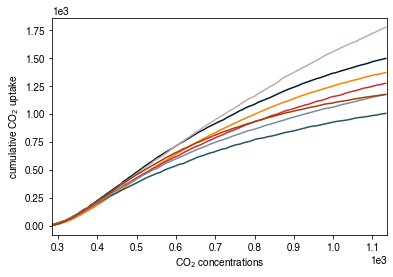

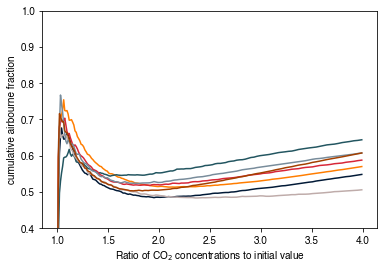

In [205]:
plt.plot(conc_1pct.loc[:1989,'CO2(ppm)'].values,model_1pct.xs('cumulative_uptake',axis=1,level=1))
plt.xlim(284,284*4)
plt.xlabel(r'CO$_2$ concentrations')
plt.ylabel(r'cumulative CO$_2$ uptake')
plt.show()

plt.plot(conc_1pct.loc[:1989,'CO2(ppm)'].values/284,model_1pct.xs('cumulative_af',axis=1,level=1))
plt.ylim(0.4,1)
plt.xlabel(r'Ratio of CO$_2$ concentrations to initial value')
plt.ylabel(r'cumulative airbourne fraction')
plt.show()

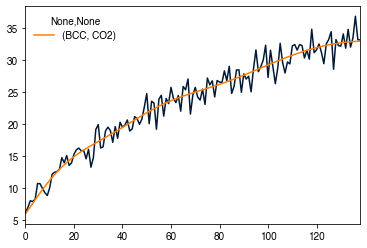

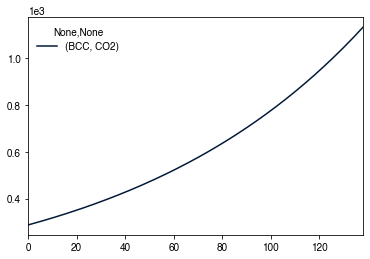

In [161]:
fig,ax = plt.subplots(1)
E = model_1pct[('BCC','E')].shift().replace(np.nan,0).diff().iloc[1:]
plt.plot(E.values)
b, a = sp.signal.butter(5, 0.05)
E_smooth = sp.signal.filtfilt(b, a, E.values.flatten())
E = pd.concat([pd.DataFrame(E_smooth,index=np.arange(0,139),columns=['CO2'])],axis=1,keys=['BCC'])
E.plot(ax=ax)

C = pd.concat([pd.DataFrame(conc_1pct.loc[1851:1989,'CO2(ppm)'].values.flatten(),index=np.arange(0,139),columns=['CO2'])],axis=1,keys=['BCC'])
C.plot()

### C$4$MIP plots (relating $\beta$ and $\gamma$ to GIR quantities)

In [213]:
CO2_params = get_gas_parameter_defaults(['CO2'])
CO2_1pct = return_empty_emissions(start_year=0,end_year=150,scen_names=['1pct_CO2'],gases_in=['CO2'])
CO2_1pct.loc[:]=278*1.01**np.arange(151)

In [240]:
CO2_params.loc['rT']=0
CO2_params.loc['rC']=0
rC_params = pd.concat([CO2_params['default']]*100,keys=np.arange(100),axis=1)
rC_params.loc['rA']=np.arange(100)/1000

In [241]:
rC_run = run_GIR(concentrations_in=CO2_1pct,gas_parameters=rC_params)

Integrating 1 scenarios, 100 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2'], between 0.0 and 150.0...


Text(0, 0.5, '$\\beta$')

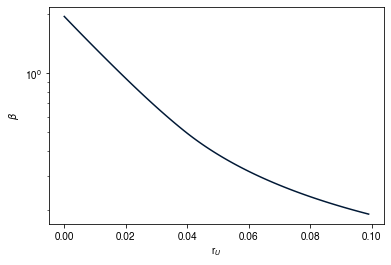

In [251]:
plt.semilogy(rC_params.loc['rA'],(rC_run['Emissions'].rolling(2).mean().cumsum().loc[139]*0.469 - 278*3) / (278*3))
plt.xlabel(r'r$_U$')
plt.ylabel(r'$\beta$')

#### Getting fgCO2 for comparison

In [22]:
import requests
import xml.etree.ElementTree as ET
import zarr
import gcsfs
import xarray as xr

In [23]:
def get_annual_CMIP6_data_esgf(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    result = esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)
    
    if not result:
        print('No results for this request')
        return None
    
    # select results with only the latest datestamp:
    latest = sorted([x.split('/')[15] for x in result])[-1]
    result = [x for x in result if x.split('/')[15]==latest]
    
    # remove duplicate results
    result_1 = []

    for item in result:
        if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
            continue
        else:
            result_1 += [item]

    ds = xr.open_mfdataset(result_1, combine='by_coords')
    
    files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
    
    if not files_area:
        print('No areacella for this request')
        return None
    
    ds_area = xr.open_dataset(files_area[0])
    
    coords = list(ds[variable].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
    else:
        dims = ['latitude','longitude']
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variable] * ds_area.areacella).sum(dim=dims) / total_area
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

In [ ]:
gs_stores = pd.read_csv('gs://cmip6/cmip6-zarr-consolidated-stores.csv')
gcs = gcsfs.GCSFileSystem(token='anon')
gs_stores.loc[:,'ism'] = gs_stores.loc[:,'institution_id'] + '_' + gs_stores.loc[:,'source_id'] + '_' + gs_stores.loc[:,'member_id']

In [64]:
def get_annual_CMIP6_data_gstore(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")
    
    if query.empty:
        print('No results for this request')
        return None

    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(query.zstore.values[0])

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    
    if source=='E3SM-1-1' and variable=='tas' and experiment=='piControl':
        ds = xr.open_mfdataset(esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment, institution_id=institution, source_id=source, member_id=member)[7:],combine='by_coords')
    
    area_query = gs_stores.query("variable_id=='areacella' & source_id==\'"+source+"\'")
    
    if area_query.empty:
        files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
        if not files_area:
            print('No areacella for this request')
            return None
        ds_area = xr.open_dataset(files_area[0])
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(area_query.zstore.values[0]), consolidated=True)
    
    coords = list(ds[variable].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
        not_dims = ['latitude','longitude']
    else:
        dims = ['latitude','longitude']
        not_dims = ['lat','lon']
        
    if not dims[0] in list(ds_area['areacella'].coords.keys()):
        areacell = ds_area.areacella.rename(dict(zip(not_dims,dims)))
    
#     print(ds[variable].coords['depth'])
    total_area = areacell.sum(dim=dims)
    ta_timeseries = (ds[variable] * areacell).sum(dim=dims) / total_area
    
    print(ta_timeseries)
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

In [65]:
def get_cmip6_data_gs(ism,var,exp,table='Amon'):
    print('getting '+ism+' '+var)
    ism_split = ism.split('_')
    _out = get_annual_CMIP6_data_gstore('CMIP', table, var, exp, ism_split[0], ism_split[1], ism_split[2])
    print('got '+ism)
    return _out

In [66]:
fgco2_ism= gs_stores.query("experiment_id=='1pctCO2' & variable_id=='fgco2'")

In [67]:
fgco2_data = {}
for ism in fgco2_ism['ism']:
    fgco2_data[ism] = get_cmip6_data_gs(ism,'fgco2','1pctCO2',fgco2_ism.loc[fgco2_ism.ism==ism,'table_id'].values[0])

getting CCCma_CanESM5_r1i1p1f1 fgco2
<xarray.DataArray (time: 1812, j: 291, i: 360)>
dask.array<truediv, shape=(1812, 291, 360), dtype=float32, chunksize=(203, 291, 360), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 ...
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 282 283 284 285 286 287 288 289 290
  * time     (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00


ValueError: cannot convert arrays with 3 dimensions into pandas objects